## **Business Overview**
***

> **About Company** :
- Perusahaan asuransi memiliki business model risk-pooling, dimana perusahaan menjual sebuah produk jaminan akan suatu hal kepada seseorang dengan mewajibkan pembayaran premi sesuai kesepakatan yang telah ditentukan. Perusahaan asuransi harus mencari nasabah sebanyak-banyak nya untuk menyebarkan resiko atas pembayaran kompensasi terhadap jaminan konsumennya. Berikut ini adalah Line 0f Business (LOB) perusahaan asuransi

1. Asuransi Umum (General insurance) - Asuransi untuk melindungi aset fisik dan tanggung jawab hukum dari kerugian finansial **ex: kendaraan motor, perjalanan, rekayasa engineering, etc**
2. Asuransi Jiwa - Asuransi untuk melindungi individu atas keselamatan/kecelakaan
3. Asuransi Kesehatan - Asuransi untuk memfasilitasi individu untuk mendapatkan manfaat kesehatan

> **Problem :**
- Sumber **pendapatan** utama perusahaan asuransi adalah pada premi yang wajib dibayarkan nasabah. Sementara klaim merupakan pertanggungan perusahaan kepada nasabah yang menjadi **pengeluaran**. Setiap periode, perusahaan asuransi perlu menetapkan premi kepada masing-masing nasabah nya berdasarkan profil resikonya. Salah satu bentuk untuk melihat profil resiko nasabah adalah meninjau karakteristik calon nasabah apakah berpotensi tinggi untuk melakukan claim atau tidak. Ketika memiliki potensi klaim, maka premi yang dibebankan harus bernilai lebih tinggi dari nasabah yang tidak berpotensi klaim
- Selain itu proses assessment claim yang diterima juga perlu di perhatikan juga untuk menurunkan biaya assessment tersebut

> **Objective and Goals :**
1. Mengetahui calon nasabah yang memiliki kecenderungan untuk claim berdasarkan karakteristik nasabah lainnya di masa lampau menggunakan pendekatan machine learning
2. Meningkatkan pendapatan perusahaan dengan menentukan premi yang tepat berdasarkan profil nasabah
3. Mempermudah proses underwriting nasabah sehingga mengehemat biaya operasional

> **Features Insight**
1. **Agency**: Nama agency - Badan yang menjual produk asuransi kepada nasabah (Frontliner).
2. **Agency Type**: Jenis asuransi - Tipe proteksi perjalanan.
3. **Distribution Channel**: Metode distribusi penjualan - Metode yang digunakan untuk berjualan.
4. **Product Name**: Nama Produk asuransi - Paket asuransi yang memiliki kemanfaatan tersendiri.
5. **Gender**: Jenis kelamin nasabah.
6. **Duration**: Lama nya waktu perjalanan.
7. **Destination**: Destinasi tujuan.
8. **Net Sales**: Netto pendapatan penjualan - Jumlah netto penjualan produk oleh agen asuransi.
9. **Commission (in value)**: Komisi yang didapatkan agen asuransi saat berhasil menjual produk.
10. **Age**: Umur nasabah yang diasuransikan.
11. **Claim**: Status klaim.

In [1]:
# Import library
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from scipy.stats import spearmanr
import missingno as msno

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from category_encoders import BinaryEncoder, OrdinalEncoder

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data_travel_insurance.csv')
df.head(5)

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


# **1. DATA CLEANING**
****

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision (in value)  44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


In [4]:
# Rename penamaan kolom
df.rename(columns={'Agency Type': 'agency_type',
                 'Distribution Channel': 'distribution_channel',
                 'Product Name':'product_name',
                 'Net Sales':'net_sales',
                 'Commision (in value)':'comision_value'},inplace=True)

df.columns = df.columns.str.lower()

In [5]:
# Menhapus duplikasi data
df=df.drop_duplicates()
print(f'Data setelah duplikasi adalah {df.shape}')

Data setelah duplikasi adalah (39661, 11)


In [6]:
df.describe(include='all')

,agency,agency_type,distribution_channel,product_name,gender,duration,destination,net_sales,comision_value,age,claim
count,39661,39661,39661,39661,11994,39661.000000,39661,39661.000000,39661.000000,39661.000000,39661
unique,16,2,2,26,2,NaN,138,NaN,NaN,NaN,2
top,EPX,Travel Agency,Online,Cancellation Plan,M,NaN,SINGAPORE,NaN,NaN,NaN,No
freq,20990,28137,38930,11009,6074,NaN,8265,NaN,NaN,NaN,38986
mean,NaN,NaN,NaN,NaN,NaN,52.397822,NaN,42.342794,10.442622,39.930284,NaN
std,NaN,NaN,NaN,NaN,NaN,113.542824,NaN,50.025244,20.355921,13.526346,NaN
min,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN,-357.500000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,11.000000,NaN,19.000000,0.000000,34.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,25.000000,NaN,29.000000,0.000000,36.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,57.000000,NaN,50.000000,11.880000,45.000000,NaN


**Key Findings**:
1. Terdapat kolom yang memiliki Null values (kolom gender)
2. Terdapat kolom yang memiliki nilai negatif (net_sales)

<Figure size 800x600 with 0 Axes>

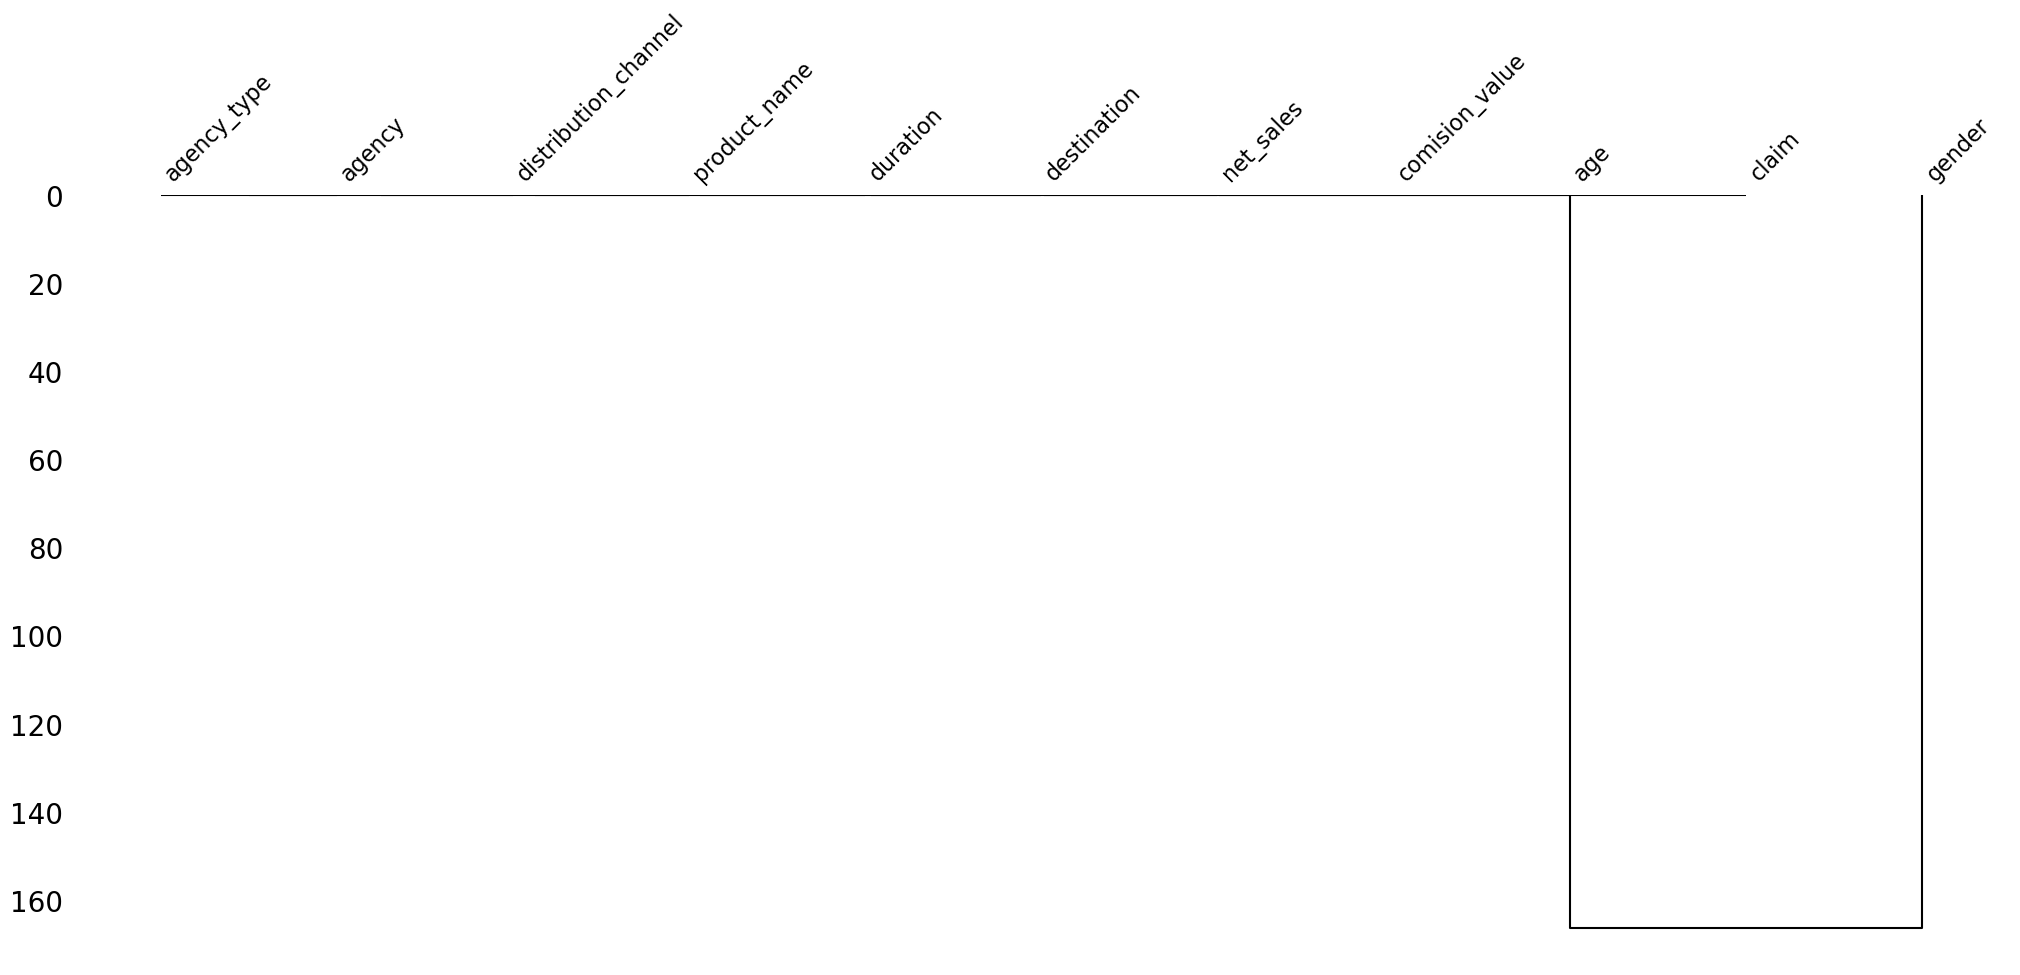

In [7]:
# Cek relasi null values pada kolom gender dengan kolom lainnya
plt.figure(figsize=(8, 6))
msno.dendrogram(df)
plt.show()


In [8]:
# Melihat Null Values
print('Persentasi NaN value di setiap kolom')
df.isna().sum()/len(df)*100

Persentasi NaN value di setiap kolom


agency                   0.000000
agency_type              0.000000
distribution_channel     0.000000
product_name             0.000000
gender                  69.758705
duration                 0.000000
destination              0.000000
net_sales                0.000000
comision_value           0.000000
age                      0.000000
claim                    0.000000
dtype: float64

**Key Findings** :
- Berdasarkan matrix dendrogram, null value yang terjadi pada kolom gender hanyak memiliki hubungan yang kecil dengan kolom age, yang artinya missing value ini bisa saja terjadi karena preferensi konsumen yang tidak mau menyebutkan identitas kelamin atau mereka cenderung berada dalam kategori lain (Non-binary). Namun dalam konteks bisnis asuransi, melengkapi data pribadi menjadi sebuah kewajiban dalam proses pendaftara travel insurance. Oleh karena itu kita akan melakukan drop pada null values di kolom gender karena dianggap sebagai anomali data.

In [9]:
# Mengisi null values dengan unknown
df= df.dropna(subset=['gender'])

In [10]:
# Melihat unique value setiap kolom
for i in df.columns:
    unique_value = df[i].unique()
    unique_value_df = pd.DataFrame(unique_value, columns = [i])
    print(f'------Infomrasi unique value pada kolom {i}------')
    display(unique_value_df)

------Infomrasi unique value pada kolom agency------


,agency
0,C2B
1,JZI
2,LWC
3,ART
4,CSR
5,KML
6,RAB
7,TST
8,TTW
9,JWT


------Infomrasi unique value pada kolom agency_type------


,agency_type
0,Airlines
1,Travel Agency


------Infomrasi unique value pada kolom distribution_channel------


,distribution_channel
0,Online
1,Offline


------Infomrasi unique value pada kolom product_name------


,product_name
0,Annual Silver Plan
1,Basic Plan
2,Bronze Plan
3,Single Trip Travel Protect Gold
4,Silver Plan
5,Value Plan
6,24 Protect
7,Annual Travel Protect Gold
8,Comprehensive Plan
9,Travel Cruise Protect


------Infomrasi unique value pada kolom gender------


,gender
0,F
1,M


------Infomrasi unique value pada kolom duration------


,duration
0,365
1,19
2,8
3,4
4,103
...,...
349,242
350,315
351,494
352,225


------Infomrasi unique value pada kolom destination------


,destination
0,SINGAPORE
1,INDIA
2,THAILAND
3,"KOREA, REPUBLIC OF"
4,VIET NAM
...,...
68,MAURITIUS
69,CZECH REPUBLIC
70,KENYA
71,OMAN


------Infomrasi unique value pada kolom net_sales------


,net_sales
0,216.00
1,22.00
2,16.00
3,26.00
4,252.85
...,...
664,180.00
665,39.76
666,265.00
667,10.46


------Infomrasi unique value pada kolom comision_value------


,comision_value
0,54.00
1,7.70
2,4.00
3,9.10
4,63.21
...,...
707,13.92
708,66.25
709,3.66
710,17.29


------Infomrasi unique value pada kolom age------


,age
0,57
1,26
2,28
3,39
4,27
...,...
84,3
85,1
86,4
87,85


------Infomrasi unique value pada kolom claim------


,claim
0,No
1,Yes


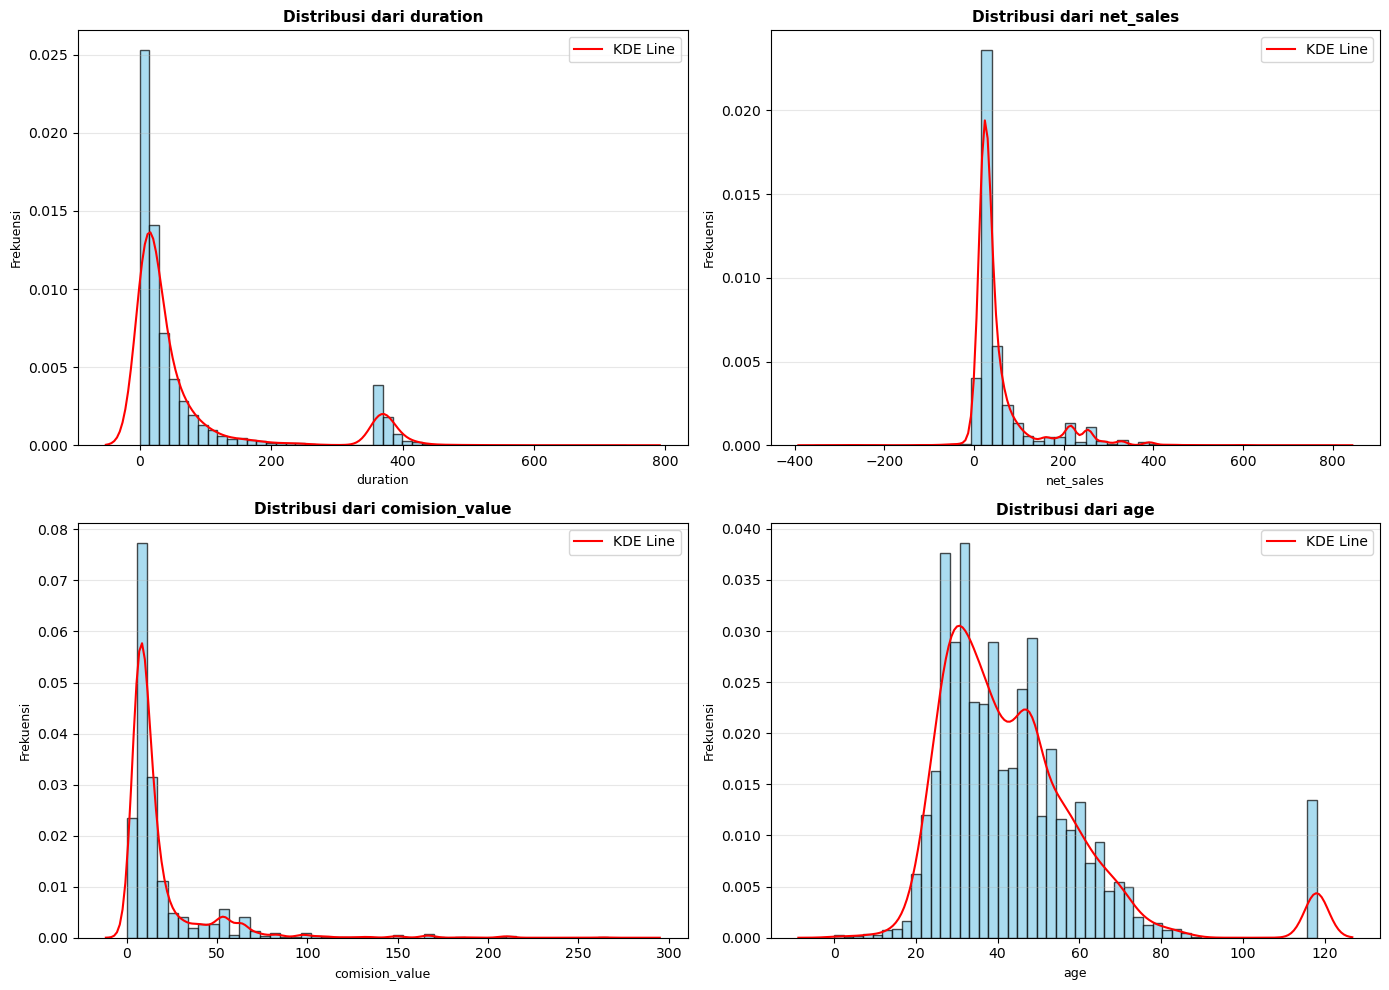

In [11]:
# Cek distribusi kolom numerikal
numerical = ['duration','net_sales','comision_value','age']

fig,axes = plt.subplots(2,2, figsize=(14,10))
ax = axes.ravel()

for i,num in enumerate (numerical):
    axe = ax[i]
    sns.kdeplot(df[num],color='red',ax=axe, label='KDE Line')

    axe.hist(df[num], bins=50, color='skyblue',edgecolor='black',alpha=0.7, density=True)
    axe.set_title(f'Distribusi dari {num}',fontsize=11, fontweight='bold')
    axe.set_xlabel(num, fontsize=9)
    axe.set_ylabel('Frekuensi',fontsize=9)
    axe.grid(axis='y',alpha=0.3)
    axe.legend()

plt.tight_layout()
plt.show()

- Dapat dilihat bahwa data memiliki cenderung untuk skewed, sehingga data dapat dikatakan tidak normal

Outliers pada kolom duration:
       duration
0           365
11          365
13          376
50          370
53          366
...         ...
44193       182
44210       378
44217       382
44224       390
44267       370

[1631 rows x 1 columns]
Persentasi outliers pada kolom duration: 13.60%


Outliers pada kolom net_sales:
       net_sales
0         216.00
11        216.00
13        252.85
41        125.00
50        204.60
...          ...
44193     130.00
44210     333.00
44217     216.00
44224     301.00
44267     333.00

[1609 rows x 1 columns]
Persentasi outliers pada kolom net_sales: 13.42%


Outliers pada kolom comision_value:
       comision_value
0               54.00
11              54.00
13              63.21
41              43.75
50             132.99
...               ...
44210           83.25
44217           54.00
44224           75.25
44267           83.25
44312           32.18

[1719 rows x 1 columns]
Persentasi outliers pada kolom comision_value: 14.33%


Outliers pa

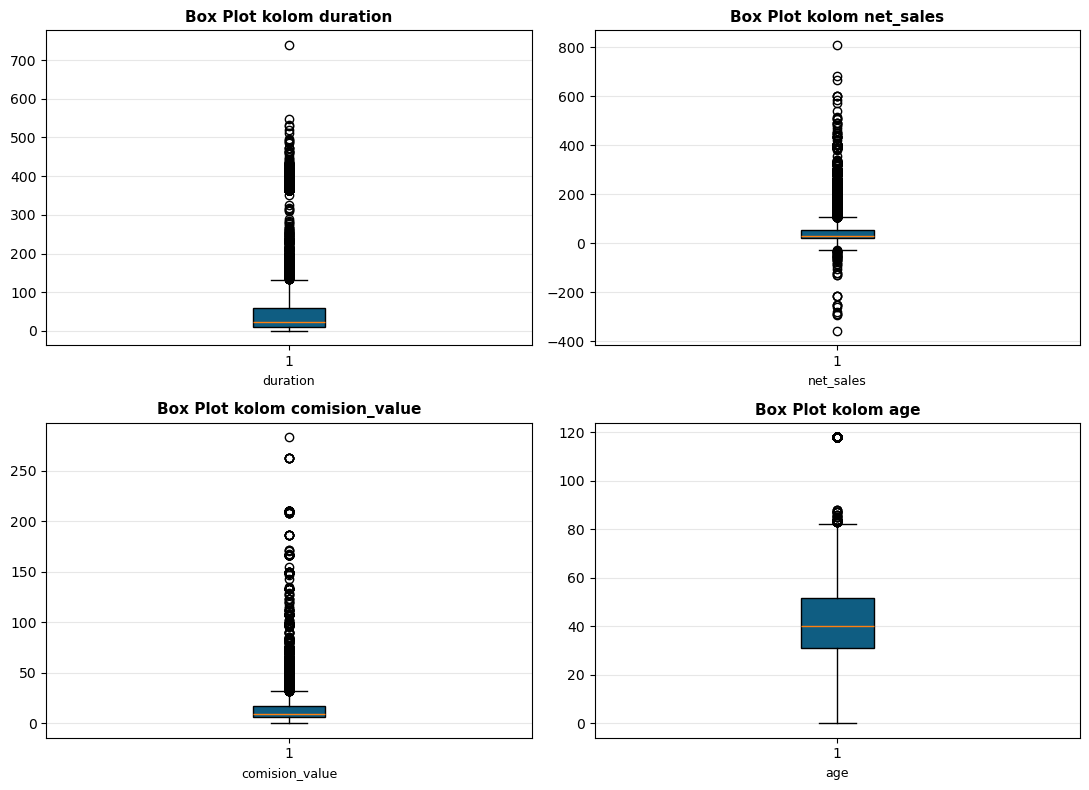

In [12]:
# Menyaring dan menghitung outliers
outliers = {}
outliers_count = {}

for v in numerical: 
    Q1 = df[v].quantile(0.25)
    Q3 = df[v].quantile(0.75)
    IQR = Q3 - Q1  # Interquartile Range

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Menyaring outliers
    outliers[v] = df[(df[v] < lower_bound) | (df[v] > upper_bound)]

    # Menghitung jumlah outliers
    outliers_count[v] = len(outliers[v])/len(df[v])*100

    print(f"Outliers pada kolom {v}:")
    print(outliers[v][[v]]) 
    print(f"Persentasi outliers pada kolom {v}: {outliers_count[v]:.2f}%")
    print("\n")

# Plot boxplot
fig, axes = plt.subplots(2, 2, figsize=(11, 8))
ax1 = axes.ravel()

for i, num in enumerate(numerical):
    axe1 = ax1[i]
    
    
    axe1.boxplot(df[num], patch_artist=True, boxprops=dict(facecolor='#0F5D82'))
    axe1.set_title(f'Box Plot kolom {num}', fontsize=11, fontweight='bold')
    axe1.set_xlabel(num, fontsize=9)
    axe1.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**Key Findings** :
- Berdasarkan Kolom durasi, net_sales, comision value, dan age memiliki rentang outliers 5-14%, angka ini dapat dikatakan cukup kecil namun kita akan meninjau lebih dalam terkait dengan masing-masing kolom yang memiliki outliers

> **Outliers kolom duration**
- Berdasarkan dengan referensi yang didapatkan, perusahaan asuransi dapat memberikan proteksi/cover kepada konsumen maximal pada 180 hari perjalanan travel. Sehingga kolom yang memiliki value lebih dari 180 hari dianggap tidak masuk akal yang terjadi kemungkinan karena kesalahan sistem ataupun input data. Sedangkan untuk perjalanan travel yang memiliki value 0 juga dianggap hal yang dapat terjadi karena perjalanan konsumen yang tidak lebih dari 24 jam
- Sehingga langkah yang diambil adalah melakukan drop pada value diatas dari 180 hari

In [13]:
df = df[df['duration'] < 180]
df

,agency,agency_type,distribution_channel,product_name,gender,duration,destination,net_sales,comision_value,age,claim
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.70,26,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.00,28,No
8,JZI,Airlines,Online,Basic Plan,M,4,THAILAND,22.0,7.70,39,No
12,JZI,Airlines,Online,Basic Plan,F,103,"KOREA, REPUBLIC OF",26.0,9.10,48,No
21,JZI,Airlines,Online,Basic Plan,M,12,VIET NAM,30.0,10.50,35,Yes
...,...,...,...,...,...,...,...,...,...,...,...
44312,LWC,Travel Agency,Online,Single Trip Travel Protect Silver,M,11,CHINA,49.5,32.18,84,No
44314,JZI,Airlines,Online,Basic Plan,M,13,THAILAND,22.0,7.70,42,No
44317,JZI,Airlines,Online,Value Plan,M,11,UNITED KINGDOM,87.0,30.45,65,No
44319,TST,Travel Agency,Offline,Travel Cruise Protect,F,94,THAILAND,30.0,10.50,0,No


> **Outliers kolom net sales & comision_value**
- Net sales merupakan total penjualan yang dilakukan agency ketika berhasil untuk menjual produk/layanan asuransi kepada konsumen, comision merupakan jumlah pendapatan setelah dikurangi beban pajak tanggungan yang diterima agensi dari perusahaan asuransi karena telah berhasil menjual produk tersebut. 
- Kita akan melihat apakah ada korelasi antara net_sales dengan komisi

In [14]:
spearman_1 = df['net_sales'].corr(df['comision_value'], method = 'spearman')
spearman_1
print(f'Nilai korelasi uji korelasi adalah {spearman_1}')
if spearman_1 >= 0.05:
    print('Terdapat korelasi dengan arah positif antara net_sales dengan comision_value')

elif spearman_1 >= -0.05:
    print('Terdapat korelasi dengan arah negatif antara net_sales dengan comision_value')

else:
    print('Tidak terdapat korelasi antara Income dan Total amount spent')

Nilai korelasi uji korelasi adalah 0.8676848385567614
Terdapat korelasi dengan arah positif antara net_sales dengan comision_value


- Kondisi nilai outliers pada net_sale bisa terjadi sesuai konteks bisnis dimana suatu tipe produk asuransi travel dijual dengan harga lebih tinggi dari tipe produk lainnya. Berhubung terdapat korelasi yang positif antara net_sales dengan comision_value menyebabkan tinggi nya komisi atas kesepakatan agen dengan perusahaan penyedia asurans.
- Kondisi net_sale bernilai negatif dapat ditemukan pula dalam konteks bisnis dimana terjadi cost yang lebih tinggi dalam menjual 1 produk layanan asuransi, sehingga hal tersebut memungkinkan untuk terjadi juga

> **Outliers kolom age**
- Berdasarkan kriteria pemberian produk asuransi, banyak referensi menyatakan bahwa batas maksimum usia untuk penerimaan produk asuransi berumur 75 tahun, sehingga kita akan drop kolom yang memiliki usia lebih dari 75 tahun. Sedangkan pemberian asuransi sudah berlaku kepada nasabah sejak berumur 0 tahun

In [15]:
df = df[df['age'] < 75]
df

,agency,agency_type,distribution_channel,product_name,gender,duration,destination,net_sales,comision_value,age,claim
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.70,26,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.00,28,No
8,JZI,Airlines,Online,Basic Plan,M,4,THAILAND,22.0,7.70,39,No
12,JZI,Airlines,Online,Basic Plan,F,103,"KOREA, REPUBLIC OF",26.0,9.10,48,No
21,JZI,Airlines,Online,Basic Plan,M,12,VIET NAM,30.0,10.50,35,Yes
...,...,...,...,...,...,...,...,...,...,...,...
44310,C2B,Airlines,Online,Silver Plan,F,16,SINGAPORE,58.0,14.50,37,No
44314,JZI,Airlines,Online,Basic Plan,M,13,THAILAND,22.0,7.70,42,No
44317,JZI,Airlines,Online,Value Plan,M,11,UNITED KINGDOM,87.0,30.45,65,No
44319,TST,Travel Agency,Offline,Travel Cruise Protect,F,94,THAILAND,30.0,10.50,0,No


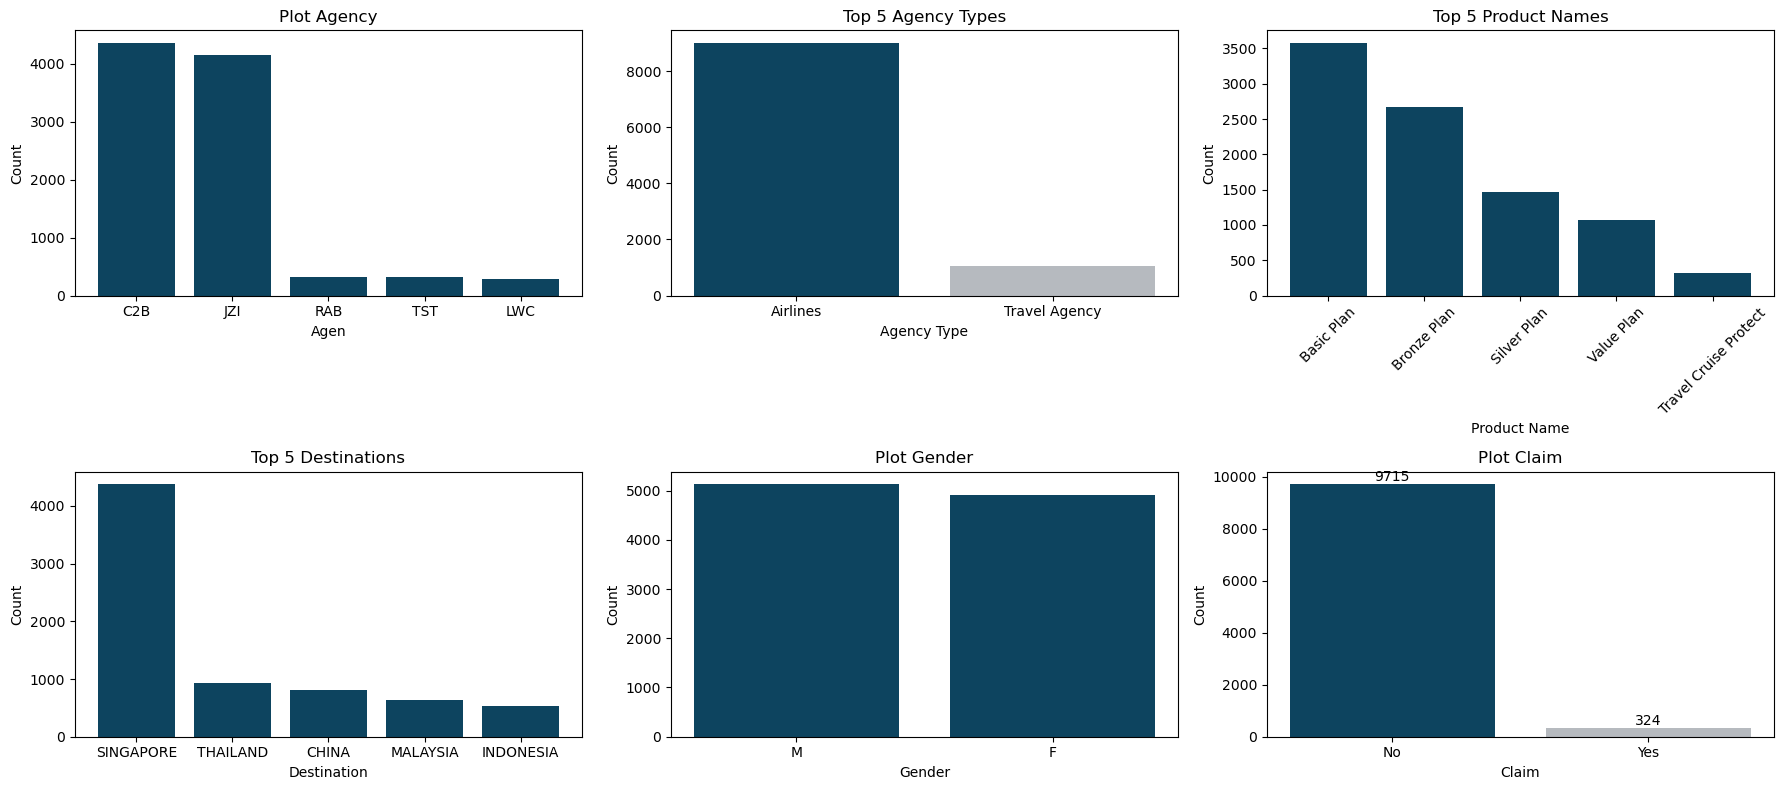

In [16]:
# membuat plot untuk kolom kategorikal

fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Gender - Menampilkan data gender
top_agency = df['agency'].value_counts().head(5)
axes[0, 0].bar(x=top_agency.index, height=top_agency.values, color='#0D445F')
axes[0, 0].set_title('Plot Agency')
axes[0, 0].set_xlabel('Agen')
axes[0, 0].set_ylabel('Count')

# Agency Type - Menampilkan data agency_type
top_agency_type = df['agency_type'].value_counts()
axes[0, 1].bar(x=top_agency_type.index, height=top_agency_type.values, color=['#0D445F', '#B6BABF'])
axes[0, 1].set_title('Top 5 Agency Types')
axes[0, 1].set_xlabel('Agency Type')
axes[0, 1].set_ylabel('Count')

# Product Name - Menampilkan 5 teratas dengan head(5)
top_product_name = df['product_name'].value_counts().head(5)
axes[0, 2].bar(x=top_product_name.index, height=top_product_name.values, color='#0D445F')
axes[0, 2].set_title('Top 5 Product Names')
axes[0, 2].set_xlabel('Product Name')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_xticklabels(top_product_name.index, rotation=45)

# Destination - Menampilkan 5 teratas dengan head(5)
top_destination = df['destination'].value_counts().head(5)
axes[1, 0].bar(x=top_destination.index, height=top_destination.values, color='#0D445F')
axes[1, 0].set_title('Top 5 Destinations')
axes[1, 0].set_xlabel('Destination')
axes[1, 0].set_ylabel('Count')

# Gender - Menampilkan data gender
top_gender = df['gender'].value_counts()
axes[1, 1].bar(x=top_gender.index, height=top_gender.values, color='#0D445F')
axes[1, 1].set_title('Plot Gender')
axes[1, 1].set_xlabel('Gender')
axes[1, 1].set_ylabel('Count')

# Claim - Menampilkan data claim
top_claim = df['claim'].value_counts()
axes[1, 2].bar(x=top_claim.index, height=top_claim.values, color=['#0D445F','#B6BABF'])
axes[1, 2].set_title('Plot Claim')
axes[1, 2].set_xlabel('Claim')
axes[1, 2].set_ylabel('Count')
for i, value in enumerate(top_claim.values):
    axes[1, 2].text(i, value + 0.5, str(value), ha='center', va='bottom')


# Atur layout agar tidak saling tumpang tindih
plt.tight_layout()
plt.show()

**Key Findings** :
- Terdapat perbandingan yang sangat besar anatara nasabah yang tidak melakukan klaim dengan klaim

In [17]:
# Mencari perbandingan total claim
claim_yes = len(df[df['claim'] == 'Yes'])
claim_no = len(df[df['claim'] == 'No'])

percentage_claim = claim_yes/len(df)*100

print(f'Persentase konsumen yang melakukan claim dari {len(df)} adalah sebesar {percentage_claim:.2f}%')

Persentase konsumen yang melakukan claim dari 10039 adalah sebesar 3.23%


**Key Findings :**
- Proporsi antara Claim 'yes' dengan 'no' memiliki perbandingan yang sangat jauh sehingga dapat menyebabkan bias saat melakukan machine learning, pada langkah berikutnya akan dilakukan metode imbalance data treatment
- Melakukan perubahan penamaan nilai pada kolom claim

In [18]:
# Merubah penulisan kolom claim menjadi 1 dan 0, dimana 1 : Yes sedangkan 0 : No
claim_mapping = {'Yes': 1, 'No':0}

df['claim']=df['claim'].map(claim_mapping)

Kolom numerik: Index(['duration', 'net_sales', 'comision_value', 'age', 'claim'], dtype='object')


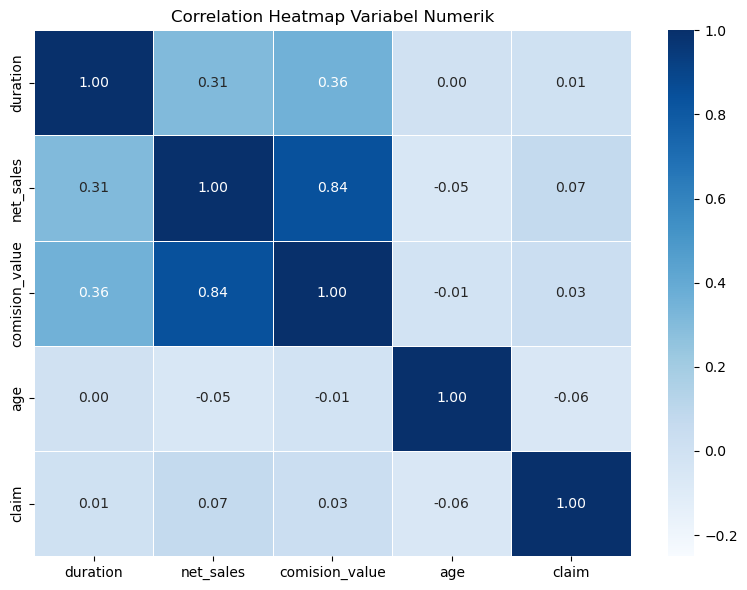

In [53]:
# melihat interaksi antara variable numerikl
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("Kolom numerik:", num_cols)

corr_matrix = df[num_cols].corr()
corr_matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    vmin=-0.25, vmax=1, 
    linewidths=0.5
)

plt.title("Correlation Heatmap Variabel Numerik")
plt.tight_layout()
plt.show()

**Key Findings :**
- Terlihat bahwa korelasi pada variable claim tidak terlihat memiliki korelasi yang besar terhadap variable lainnya

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10039 entries, 2 to 44325
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   agency                10039 non-null  object 
 1   agency_type           10039 non-null  object 
 2   distribution_channel  10039 non-null  object 
 3   product_name          10039 non-null  object 
 4   gender                10039 non-null  object 
 5   duration              10039 non-null  int64  
 6   destination           10039 non-null  object 
 7   net_sales             10039 non-null  float64
 8   comision_value        10039 non-null  float64
 9   age                   10039 non-null  int64  
 10  claim                 10039 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 941.2+ KB


# **2. Preprocessing**
****

> **Menentukan strategi Preprocessing**
> **Feature Engineering**
1. Scaling : 
   - Robust scaler : duration, net_sales, comision_value, age
- **Alasan** : robust scaler digunakan pada data yang memiliki outliers untuk mengeneralisir data dan cocok untuk data yang berdistribusi tidak normal

2. Encoding :
   - One hot encoding : gender, distribution_channel, agency_type
 - **Alasan** : Untuk mengubah kolom kategorikal menjadi numerical yang < 5 value
   - Binary encoding : agency, product_name, destination
 - **Alasan** : Untuk mengubah kolom kategorikal menjadi numerical untuk value yang >5 item

> **Menentukan metrics penilaian**
- Berdasarkan business problem objective, perusahaan ingin mengetahui potensi konsumen nya akan melakukan claim menggunakan pendekatan machine learning berdasarkan klasifikasi label nasabah. **Nilai 1** untuk melabelkan nasabah yang akan klaim sedangkan **Nilai 0** untuk melabelkan nasabah yang tidak klaim
- Berdasarkan resiko kerugian bisnis asuransi, resiko **salah melakukan prediksi nasabah tidak melakukan klaim (0) namun secara aktual nasabah melakukan klaim (1) memiliki dampak resiko kerugian** kepada bisnis. Oleh karena itu sesuai dengan konteks bisnis model machine learning akan di evaluasi menggunakan penilaian **Recall** untuk melihat **False Negative (FN)**

In [21]:
#2.1 Set up Train dan Tes Data
def split_data():
    x= df.drop(["claim"], axis=1)
    y=df["claim"]
    xtrain, xtest, ytrain, ytest = train_test_split(
    x, y,
    test_size=0.2,
    random_state=42,
    stratify=y)
    return xtrain, xtest, ytrain, ytest

# 2.2 Pipeline Processing

prepros = ColumnTransformer([
    ('Standard Scaler', RobustScaler(), ['duration','net_sales','age','comision_value']),
    ('Binary Encoding', BinaryEncoder(), ['agency','product_name','destination']),
    ('OHE', OneHotEncoder(drop='first',handle_unknown='ignore'), ['gender','distribution_channel','agency_type'])
], remainder='passthrough')

prepros

print('Preprocessing telah selesai...')

Preprocessing telah selesai...


In [22]:
xtrain,xtest,ytrain,ytest = split_data()
X_train_transformed = prepros.fit_transform(xtrain)

## **3. Model Benchmarking**
***

In [23]:
# 3.1 Initialized model with resampling method

# definisi sampling method
ros = RandomOverSampler(random_state=42)
smote=SMOTE(random_state=42)

# definisi kfold
kfold = StratifiedKFold(random_state=42, n_splits=5, shuffle=True)

# Base model
rf = RandomForestClassifier(random_state = 42, n_estimators=100)
dt = DecisionTreeClassifier(random_state=42)
svc = SVC(class_weight='balanced')
logreg =LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
gb = GradientBoostingClassifier(random_state=42, n_estimators=100)
xbg = XGBClassifier(n_estimators = 100, random_state=42)
lgbm = LGBMClassifier(random_state=42, n_estimators=100)

In [24]:
# 3.2 Prepare untuk run model

model = [rf,dt,svc,logreg,knn,gb,xbg,lgbm]
namamodel1 = ['RandomForestClassifier (ROS)','RandomForestClassifier (smote)',
             'DecisionTreeClassifier (ROS)','DecisionTreeClassifier (smote)',
             'SVM (ROS)','SVM (smote)',
             'LogisticRegression (ROS)','LogisticRegression (smote)',
             'KNN (ROS)','KNN (smote)',
             'Gradient Boosting (ROS)','Gradient Boosting (smote)',
             'XG Boosting (ROS)','XG Boosting (smote)',
             'LG Boosting (ROS)','LG Boosting (smote)']
score_mean = []
score_std = []
for i in model:
    for j in [ros,smote]:
        pipeline = Pipeline([('Preprocesing', prepros),
                             ('Resampling', j),
                             ('Model', i)])
        xtrain,xtest,ytrain,ytest = split_data()
        cv = cross_val_score(pipeline, xtrain,ytrain, cv=kfold, scoring='recall')

        score_mean.append(cv.mean())
        score_std.append(cv.std())

ringkasan = pd.DataFrame({'Model': namamodel1, 'AVG Recall Score': score_mean,'STD Recall':score_std}).sort_values('AVG Recall Score',ascending=False)
ringkasan

[LightGBM] [Info] Number of positive: 6217, number of negative: 6217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 12434, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 6217, number of negative: 6217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 721
[LightGBM] [Info] Number of data points in the train set: 12434, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,Model,AVG Recall Score,STD Recall
6,LogisticRegression (ROS),0.876471,0.046407
7,LogisticRegression (smote),0.864932,0.043663
4,SVM (ROS),0.799321,0.039158
5,SVM (smote),0.760558,0.038034
10,Gradient Boosting (ROS),0.640649,0.078955
11,Gradient Boosting (smote),0.478356,0.083644
9,KNN (smote),0.339744,0.049321
14,LG Boosting (ROS),0.262594,0.079514
3,DecisionTreeClassifier (smote),0.146757,0.026291
8,KNN (ROS),0.139065,0.044747


In [25]:
# 3.3 Initialized model dengan panalized method (hanya logreg, dt,rf, dan svc)
rf_panalized = RandomForestClassifier(random_state = 42, max_depth=10, n_estimators=100, class_weight='balanced')
dt_panalized = DecisionTreeClassifier(random_state=42, max_depth=10, class_weight='balanced')
svc_panalized = SVC(class_weight='balanced')
logreg_panalized = LogisticRegression(random_state=42, class_weight='balanced')

model_panalized = [rf_panalized,dt_panalized,svc_panalized,logreg_panalized]
namamodel_panalized = ['RandomForestClassifier (P)','DecisionTreeClassifier (P)','SVM (P)','LogisticRegression (P)']

In [26]:
# 3.4 Prepare untuk run model panalized method

score_mean_panalized =[]
score_std_panalized=[]

for i in model_panalized:
    pipeline_panalized = Pipeline([
        ('Preprocesing', prepros),
        ('Model', i)
    ])
    xtrain,xtest,ytrain,ytest = split_data()
    cv_panalized = cross_val_score(pipeline_panalized, xtrain,ytrain, cv=kfold, scoring='recall')

    score_mean_panalized.append(cv_panalized.mean())
    score_std_panalized.append(cv_panalized.std())

ringkasan_panalized = pd.DataFrame({'Model': namamodel_panalized, 'AVG Recall Score': score_mean_panalized,'STD Recall':score_std_panalized}).sort_values('AVG Recall Score',ascending=False)
ringkasan_panalized

,Model,AVG Recall Score,STD Recall
3,LogisticRegression (P),0.876471,0.046407
2,SVM (P),0.810860,0.044308
1,DecisionTreeClassifier (P),0.652338,0.157573
0,RandomForestClassifier (P),0.563801,0.082499


## **4. Modeling data test**
***

> Berdasarkan hasil modeling, terdapat 3 model terbaikk yang akan dipilih
- Logistic Regression (panalized)
- Logistic Regression (smote)
- SVM (panalized)

**4.1 Logistic regression panalized**

In [27]:
# Pilih model terbaik berdasarkan hasil cross-validation, yaitu Logistic Regression (Panalized)
best_model_lg_panalized = LogisticRegression(random_state=42,class_weight='balanced')

pipeline_lg_panalized = Pipeline([
    ('Preprocessing', prepros),
    ('Model', best_model_lg_panalized)
])
xtrain,xtest,ytrain,ytest = split_data()
pipeline_lg_panalized.fit(xtrain, ytrain)

y_pred_lg_panalized = pipeline_lg_panalized.predict(xtest)
recall_lg_panalized = recall_score(ytest, y_pred_lg_panalized)

logistisc_regression_panalized = pd.DataFrame({'Model': ['Logistic Regression (Panalized)'], 'Recall Score': [recall_lg_panalized]})
logistisc_regression_panalized

,Model,Recall Score
0,Logistic Regression (Panalized),0.892308


**4.2 Logistic regression smote**

In [28]:
# Pilih model terbaik berdasarkan hasil cross-validation, yaitu Logistic Regression (Panalized)
best_model_lg_smote = LogisticRegression(random_state=42)

pipeline_lg_smote = Pipeline([
    ('Preprocessing', prepros),
    ('Imbalance', smote),
    ('Model', best_model_lg_smote)
])
xtrain,xtest,ytrain,ytest = split_data()
pipeline_lg_smote.fit(xtrain, ytrain)

y_pred_lg_smote = pipeline_lg_smote.predict(xtest)
recall_lg_smote = recall_score(ytest, y_pred_lg_smote)

logistisc_regression_smote = pd.DataFrame({'Model': ['Logistic Regression (Smote)'], 'Recall Score': [recall_lg_smote]})
logistisc_regression_smote

,Model,Recall Score
0,Logistic Regression (Smote),0.876923


**4.3 SVM (Panalized)**

In [29]:
# Pilih model terbaik berdasarkan hasil cross-validation, yaitu Logistic Regression (Panalized)
best_model_svm_panalized = SVC(class_weight='balanced')

pipeline_svm_panalized = Pipeline([
    ('Preprocessing', prepros),
    ('Model', best_model_svm_panalized)
])
xtrain,xtest,ytrain,ytest = split_data()
pipeline_svm_panalized.fit(xtrain, ytrain)

y_pred_svm_panalized = pipeline_svm_panalized.predict(xtest)
recall_svm_panalized = recall_score(ytest, y_pred_svm_panalized)

svm_panalized = pd.DataFrame({'Model': ['SVM Panalized'], 'Recall Score': [recall_svm_panalized]})
svm_panalized

,Model,Recall Score
0,SVM Panalized,0.830769


**Kesimpulan Model train dan test**

In [30]:
# Mengambil hasil data train dan test top 3 model

# Mengambil data train Logreg smote
logreg_smote_row = ringkasan[ringkasan['Model'] == 'LogisticRegression (smote)']
logreg_smote_value = logreg_smote_row['AVG Recall Score'].values[0]
# Mengambil data train Logreg panalized
logreg_panalized_row = ringkasan_panalized[ringkasan_panalized['Model'] == 'LogisticRegression (P)']
logreg_panalized_value = logreg_panalized_row['AVG Recall Score'].values[0]
# Mengambil data train SVM panalized
svm_panalized_row = ringkasan_panalized[ringkasan_panalized['Model'] == 'SVM (P)']
svm_panalized_value = svm_panalized_row['AVG Recall Score'].values[0]

# Mengelompokkan data
train_score = [logreg_smote_value,logreg_panalized_value,svm_panalized_value]
test_score = [recall_lg_smote,recall_lg_panalized,recall_svm_panalized]


model_benchmarking_result = pd.DataFrame({'Model': ['Logistic Regression (Smote)','Logistic Regression (Panalized)','SVM Panalized'], 'Recall Train': train_score, 'Recall Test':test_score})
model_benchmarking_result['Delta Reesult (Train - Recall)'] = model_benchmarking_result['Recall Train'] - model_benchmarking_result['Recall Test']
model_benchmarking_result.sort_values(by = 'Delta Reesult (Train - Recall)', ascending = False)


,Model,Recall Train,Recall Test,Delta Reesult (Train - Recall)
0,Logistic Regression (Smote),0.864932,0.876923,-0.011991
1,Logistic Regression (Panalized),0.876471,0.892308,-0.015837
2,SVM Panalized,0.810860,0.830769,-0.019910


## **5. Model Tunning**
****

**5.1 Logistic Regression (Panalized)**

In [31]:
# Pilih model logistic regression panalized untuk tuning 
grid_lg_panalized = LogisticRegression(random_state=42, class_weight='balanced')

pipeline_lg_panalized_gridsearch = Pipeline([
    ('Preprocessing', prepros),
    ('Model', grid_lg_panalized)
])

param_grid = {
    'Model__C': [0.1, 0.05, 0.01, 0.005],
    'Model__penalty': ['l2'],
    'Model__solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
    'Model__max_iter': [100, 200, 300],
}
xtrain,xtest,ytrain,ytest = split_data()

grid_search_lg_panalized = GridSearchCV(pipeline_lg_panalized_gridsearch, 
                           param_grid=param_grid, 
                           cv=kfold, 
                           scoring='recall',
                           n_jobs=-1)
grid_search_lg_panalized.fit(xtrain,ytrain)

print("Best parameters found by GridSearchCV:")
print(grid_search_lg_panalized.best_params_)

scoring_lg_panalized = grid_search_lg_panalized.best_score_
scoring_lg_panalized

Best parameters found by GridSearchCV:
{'Model__C': 0.1, 'Model__max_iter': 100, 'Model__penalty': 'l2', 'Model__solver': 'lbfgs'}


np.float64(0.8764705882352942)

In [32]:
# Implementasi ke dalam model test
lg_panalized_tuned = grid_search_lg_panalized.best_estimator_
xtrain,xtest,ytrain,ytest = split_data()
lg_panalized_tuned.fit(xtrain, ytrain)
ypred_lg_panalized_tuned = lg_panalized_tuned.predict(xtest)
recall_lg_panalized_tuned = recall_score(ytest, ypred_lg_panalized_tuned)
recall_lg_panalized_tuned

0.8923076923076924

**5.2 Logistic Regression (Smote**)

In [33]:
# Pilih model logistic regression panalized untuk tuning 
grid_lg_smote = LogisticRegression(random_state=42)

pipeline_lg_smote_gridsearch = Pipeline([
    ('Preprocessing', prepros),
    ('Imbalance', smote),
    ('Model', grid_lg_smote)
])

param_grid = {
    'Model__C': [0.1, 0.05, 0.01, 0.005],
    'Model__penalty': ['l2'],
    'Model__solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
    'Model__max_iter': [100, 200, 300],
}
xtrain,xtest,ytrain,ytest = split_data()

grid_search_lg_smote = GridSearchCV(pipeline_lg_smote_gridsearch, 
                           param_grid=param_grid, 
                           cv=kfold, 
                           scoring='recall',
                           n_jobs=-1)
grid_search_lg_smote.fit(xtrain,ytrain)

print("Best parameters found by GridSearchCV:")
print(grid_search_lg_smote.best_params_)

scoring_lg_smote = grid_search_lg_smote.best_score_
scoring_lg_smote

Best parameters found by GridSearchCV:
{'Model__C': 0.1, 'Model__max_iter': 100, 'Model__penalty': 'l2', 'Model__solver': 'lbfgs'}


np.float64(0.8649321266968325)

In [34]:
# Implementasi ke dalam model test
lg_smote_tuned = grid_search_lg_smote.best_estimator_
xtrain,xtest,ytrain,ytest = split_data()
lg_smote_tuned.fit(xtrain, ytrain)
ypred_lg_panalized_tuned = lg_smote_tuned.predict(xtest)
recall_lg_smote_tuned = recall_score(ytest, ypred_lg_panalized_tuned)
recall_lg_smote_tuned

0.8769230769230769

**5.3 SVM**

In [35]:
# Pilih model logistic regression panalized untuk tuning 
grid_svm = SVC(class_weight='balanced')

pipeline_svm_panalized_gridsearch = Pipeline([
    ('Preprocessing', prepros),
    ('Model', grid_svm)
])

param_grid_svc = {
    'Model__kernel': ['rbf', 'poly'],
    'Model__degree': [3, 5, 7],
}

xtrain,xtest,ytrain,ytest = split_data()

grid_search_svm = GridSearchCV(pipeline_svm_panalized_gridsearch, 
                           param_grid=param_grid_svc, 
                           cv=kfold, 
                           scoring='recall',
                           n_jobs=-1)
grid_search_svm.fit(xtrain,ytrain)

print("Best parameters found by GridSearchCV:")
print(grid_search_svm.best_params_)

scoring_svm_grid = grid_search_svm.best_score_
scoring_svm_grid

Best parameters found by GridSearchCV:
{'Model__degree': 3, 'Model__kernel': 'poly'}


np.float64(0.8187028657616893)

In [36]:
# Implementasi ke dalam model test
svm_panalized_tuned = grid_search_svm.best_estimator_
xtrain,xtest,ytrain,ytest = split_data()
svm_panalized_tuned.fit(xtrain, ytrain)
ypred_svm_panalized_tuned = svm_panalized_tuned.predict(xtest)
recall_svm_panalized_tuned = recall_score(ytest, ypred_svm_panalized_tuned)
recall_svm_panalized_tuned

0.8461538461538461

## **6. Final**
***

In [37]:
# Finalisasi model
train_score_tuned = [scoring_lg_smote,scoring_lg_panalized,scoring_svm_grid]
test_score_tuned = [recall_lg_smote_tuned,recall_lg_panalized_tuned,recall_svm_panalized_tuned]
model_final = pd.DataFrame({'Model': ['Logistic Regression (Smote)','Logistic Regression (Panalized)','SVM Panalized'], 'Recall Train': train_score, 'Recall Test':test_score,
                                           'Recall Train (Tuned)': train_score_tuned, 'Recall Test (Tuned)':test_score_tuned })
model_final['Delta Result (Train - Recall)'] = model_final['Recall Train'] - model_final['Recall Test']
model_final['Delta Result (Train - Recall) tuned'] = model_final['Recall Train (Tuned)'] - model_final['Recall Test (Tuned)']
model_final.sort_values(by = 'Delta Result (Train - Recall) tuned', ascending = False)

,Model,Recall Train,Recall Test,Recall Train (Tuned),Recall Test (Tuned),Delta Result (Train - Recall),Delta Result (Train - Recall) tuned
0,Logistic Regression (Smote),0.864932,0.876923,0.864932,0.876923,-0.011991,-0.011991
1,Logistic Regression (Panalized),0.876471,0.892308,0.876471,0.892308,-0.015837,-0.015837
2,SVM Panalized,0.810860,0.830769,0.818703,0.846154,-0.019910,-0.027451


Intercept (β0): -2.645153883049697

Top 10 features with the highest |Beta| values:
                             Feature      Beta  Abs_Beta
20  OHE__distribution_channel_Online  1.504709  1.504709
14    Binary Encoding__destination_2 -0.945185  0.945185
21    OHE__agency_type_Travel Agency  0.775743  0.775743
6          Binary Encoding__agency_2  0.747195  0.747195
13    Binary Encoding__destination_1 -0.667687  0.667687
16    Binary Encoding__destination_4 -0.658111  0.658111
4          Binary Encoding__agency_0 -0.645436  0.645436
10   Binary Encoding__product_name_2  0.457835  0.457835
17    Binary Encoding__destination_5  0.443549  0.443549
11   Binary Encoding__product_name_3 -0.287805  0.287805


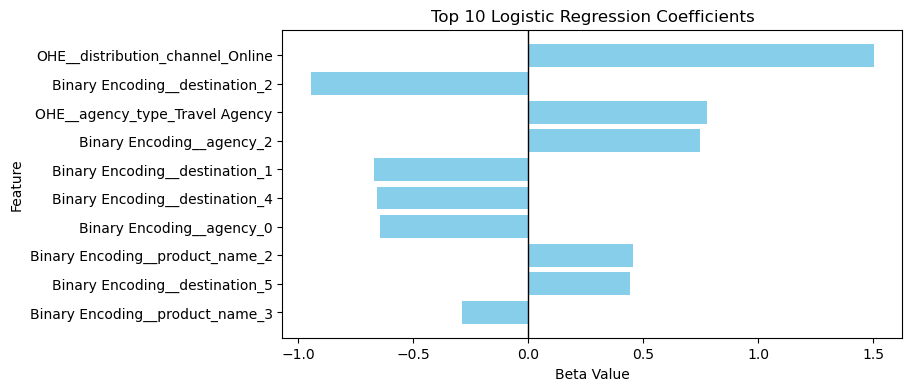

In [58]:
# Get feature names after preprocessing (pipeline transformations)
feature_names = lg_smote_tuned.named_steps["Preprocessing"].get_feature_names_out()

# Extract logistic regression coefficients (beta values)
betas = lg_smote_tuned.named_steps["Model"].coef_[0]
intercept = lg_smote_tuned.named_steps["Model"].intercept_[0]

# Create a DataFrame with feature names and coefficients
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Beta": betas,
    "Abs_Beta": np.abs(betas)  # absolute value for ranking
}).sort_values(by="Abs_Beta", ascending=False)

# Print intercept and top 10 features by absolute coefficient values
print("Intercept (β0):", intercept)
print("\nTop 10 features with the highest |Beta| values:")
print(coef_df.head(10))

# Plot bar chart of the top 10 coefficients
top10 = coef_df.head(10)
plt.figure(figsize=(8,4))
plt.barh(top10["Feature"], top10["Beta"], color="skyblue")
plt.axvline(0, color="black", linewidth=1)  # reference line at 0
plt.title("Top 10 Logistic Regression Coefficients")
plt.xlabel("Beta Value")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # highest values on top
plt.show()

**Key Findings**
1. Koefisien yang bernilai positif akan berdampak kepada semakin tingginya probabilitas suatu data untuk diprediksi menjadi kelas positif (1)
2. Koefisien yang bernilai negatif akan berdampak kepada semakin turunnya probabilitas suatu data untuk diprediksi menjadi kelas positif (1)

**Model conclusion**

Model **Logistic Regression** dengan metode **SMOTE** oversampling memiliki peforma skor Recall yang lebih baik terlihat dari skor train dan test serta saling mendekati. Hal ini dapat dikatakan bahwa model adalah best fitting dengan kemampuan prediksi generalisasi yang baik.

> **Evaluation Matrics**

In [45]:
# Buat pipeline final dengan model terbaik (LogReg)
pipeline_final = Pipeline([
    ('Preprocessing', ColumnTransformer([
    ('Standard Scaler', RobustScaler(), ['duration','net_sales','age','comision_value']),
    ('Binary Encoding', BinaryEncoder(), ['agency','product_name','destination']),
    ('OHE', OneHotEncoder(drop='first',handle_unknown='ignore'), ['gender','distribution_channel','agency_type'])
], remainder='passthrough')),
    ('Imbalance', SMOTE(random_state=42)),
    ('Model', LogisticRegression(random_state=42))
])
print('Melatih model train terlebih dahulu....')
pipeline_final.fit(xtrain, ytrain)
print('Model train selesai dilatih....')

y_pred_final = pipeline_final.predict(xtest)

# Buat scoring evaluation
print(classification_report(ytest,y_pred_final ))
print(confusion_matrix(ytest, y_pred_final))

Melatih model train terlebih dahulu....
Model train selesai dilatih....
              precision    recall  f1-score   support

           0       0.99      0.58      0.73      1943
           1       0.06      0.88      0.12        65

    accuracy                           0.59      2008
   macro avg       0.53      0.73      0.42      2008
weighted avg       0.96      0.59      0.71      2008

[[1119  824]
 [   8   57]]


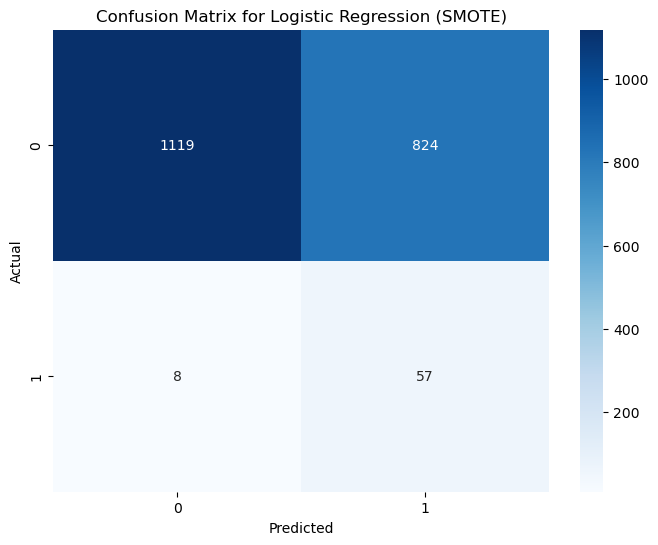

In [54]:
# Plot confusion matrix
conf_matrix = confusion_matrix(ytest, y_pred_final)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression (SMOTE)')
plt.show()

**Key Findings**
- Accuracy menjelaskan persentase dari semua prediksi (klaim dan tidak klaim) yang dimana model dapat memprediksikannya dengan benar. Berdasarkan model machine learning yang telah dibangun memiliki akurasi sebsar 59%
- Precision menjelaskan seberapa banyak prediksi klaim yang secara aktual klaim. Dengan skor sebesar 6% menyatakan bahwa dari semua prediksi yang dinyatakan klaim, hanya sebesar 6% yang benar klaim secara aktual. Ini merupakan sebuah konsekuensi ketika kita mengharapkan model machine learning baik secara Recall
- Recall claim class (1) menjelaskan bahwa seberapa baik model menemukan klaim aktual pada data nyata. Nilai 88% menunjukkan bahwa model telah berhasil mengidentifikasi 88% dari klaim nyata sisanya terlewatkan oleh model

In [44]:
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]

total_no_claim = TP + FP
total_claim = TN + FN

print(f"Jumlah sampel data uji (xtest): {xtest.shape[0]}")
print(f'Total claim : {total_claim} Total tidak claim : {total_no_claim}')
print(f'Total True Positive (TP) : {TP}, dimana aktual claim dan diprediksi klaim')
print(f'Total True Positive (TN) : {TN}, dimana aktual tidak claim dan diprediksi tidak claim')
print(f'Total True Positive (TN) : {FP}, dimana aktual tidak claim dan diprediksi claim')
print(f'Total True Positive (TN) : {FN}, dimana aktual claim dan diprediksi tidak claim')

Jumlah sampel data uji (xtest): 2008
Total claim : 1127 Total tidak claim : 881
Total True Positive (TP) : 57, dimana aktual claim dan diprediksi klaim
Total True Positive (TN) : 1119, dimana aktual tidak claim dan diprediksi tidak claim
Total True Positive (TN) : 824, dimana aktual tidak claim dan diprediksi claim
Total True Positive (TN) : 8, dimana aktual claim dan diprediksi tidak claim


> **Cost Benefit Analysis**

**Asumsi Bisnis**
Berdasarkan business understanding, kita dapat mengasumsikan beberapa perhitungan sebagai berikut :

- Premi pembayaran: Biasanya total premi yang harus dibayar adalah sejumlah $200
- Biaya proses claim: Biaya untuk assessment klaim sebesar $100
- Biaya cover asuransi : $1000
- Total Polis : 2008 (TP+TN+FP+FN)
- Berdasarkan persentase klaim data aktual, ditemukan bahwa hanya 3% nasabah pemegang polis yang melaukan proses klaim

**Berdasarkan asumsi diatas kita akan membuat analisa keuntungan dalam penghematan proses klaim asuransi**

**Tanpa Machine Learning**

1. Total polis : 2008
2. Ekspektasi klaim (3% dari total pemegang polis): 60 (klaim aktual)
3. Cost :
   - Cost karena biaya assessment : 2008 x $200 = $401,600
   - Aktual klaim : 60 x $1000 = $60,000
   - Total cost tanpa ML : $401,600 + $60,000 = $461,600

**Dengan Machine Learning**

1. Total polis : 2008
2. Cost :
   - Proses assessment
     - Cost karena biaya assessment : (TP + FN) (57+8) X $200 = $13,000
     - Cost karena salah identifikasi non-klaim : (FP) (824) X $200 = $164,000
   - Prediksi klaim :
     - Cost karena TP : 57 X $1000 = $57,000
     - Cost karena FN : 8 x $1000 = $8000
   - Total cost yang ditanggung : $13,000 + $164,000 + $57,000 + $8000 = $242,000

**Total cost saving**
1. Total cost tanpa machine learning : $461,600
2. Total cost dengan machine learning : $242,000
3. Total penghematan : $219,000

**Key Driver**
1. Penghematan biaya ditunjukkan pada cost assessment dari setiap pemegang polis. Dengan menggunakan machine learning, kita bisa memfokuskan assessment tertuju pada kategori pemegang polis yang terindikasi melakukan klaim
2. Disamping itu, cost pembayaran klaim memeberikan cost yang lebih tinggi saat menggunakan machine learning

> **Limitasi Model**

1. Model hanya sesuai apabila memprediksi data baru dengan jumlah dan nilai fitur yang sama seperti yang dilakukan pada model train dan test
2. Dikarenakan model menggunakan data historis sebagai pembelajaran, maka melakukan retraining sangat diperlukan
3. Model tidak bisa digunakan apabila terdapat faktor eksternal seperti pandemi, krisis, dan bencana alam 

> **Rekomendasi**

**Business**
1. **Penentuan premi berdasarkan faktor resiko**  
   - Model dapat digunakan untuk menentukan kategoriasi resiko pemegang polis :  
     - Prediksi klaim tinggi -> sesuaikan premi untuk mengcover cost.  
     - Prediksi klaim tinggi -> sesuaikan premi dengan harga yang cukup rendah dan kompetitif di pasar.  

2. **Segmentasi pasar**  
   - Segmentasi dapat dilakukan melihat dari tipe resikonya.  
   - Fokus kepada **low-medium risk** dikarenakan segmen mayoritas pemegang polis tidak melakukan klaim  

3. **Operational Risk Management**  
   - Alokasi dana assessment untuk keperluan penetrasi kepada calon pemegang polis yang beresiko tinggi.  

**Model machine learning**
1. Lakukan training ulang secara berkala untuk menyesuakian pola data pemegang polis
2. Monitor metriks penilaian secara berkala untuk menjaga konsistensi prediksi
3. Mengaplikasikan metode lain untuk imbalance data dan feature engineering